# AUC Course Recommender
## Description
In this notebook is the source code for the Amsterdam University College (AUC) Course Recommender. This course recommender is part of a project for the Text Mining course.

## Code
### Imports:

In [247]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

### Loading and Preprocessing the Data

Loading the data in as a pandas dataframe:

In [248]:
data = pd.read_csv("datasets/recommender_dataset.csv")
print(data.shape)

(3812, 8)


Next we drop the rows which have nothing in the course_catalogue_number column. These rows are empty because the course scraper did not scrape information from courses whose websites were not written in English, meaning that after dropping these rows all courses in the dataset are taught in English.

In [249]:
courses = data.dropna(subset=['course_catalogue_number', 'is_part_of', 'language_of_instruction', 'course_description'])
print(courses.shape)

(3345, 8)


Example of course description before preprocessing:

In [250]:
print(courses.iloc[0]["course_description"])
print("LENGTH:" ,len(courses.iloc[0]["course_description"]))

Upon completing this course, you should be able to: identify and use different schools of thought in strategic management based on a solid understanding of their assumptions, strengths and weaknesses; critically reflect on different theories and perspectives in relation to competitive and cooperative strategy and compare them with alternative views; select, apply and combine analytical tools in diagnosing or addressing strategic issues at the business and network level in real-life cases; analyse the competitive, cooperative and coopetitive strategies of organizations, assess the impact of changes in these strategies, and formulate recommendations for improvement; adequately analyse the external and internal environment of an organization to derive relevant insights that can inform strategic decision-making; identify when and how to change or modify a business model over time and recognize relevant enabling and inhibiting factors; map the ecosystem(s) and alliance networks in which org

Now we remove the stop words from dataframe's columns, as these act as noise that do not add much discriminative value in terms of similarity. 

In [251]:
courses = courses.reset_index(drop=True)
for i in range(len(courses)):
    courses.loc[i, 'course_name'] = courses.loc[i, 'course_name'].lower()
    courses.loc[i, 'college_graduate'] = courses.loc[i, 'college_graduate'].lower()
    courses.loc[i, 'language_of_instruction'] = courses.loc[i, 'language_of_instruction'].lower()
    courses.loc[i, 'is_part_of'] = courses['is_part_of'][i].lower()
    courses.loc[i, 'is_part_of'] = remove_stopwords(courses.loc[i, 'is_part_of'])
    courses.loc[i, 'course_description'] = courses.loc[i, "course_description"].lower()
    courses.loc[i, 'course_description'] = remove_stopwords(courses.loc[i, 'course_description'])

We also remove punctuation from the text, as this also acts as noise:

In [252]:
for i in range(len(courses)):
    courses.loc[i, 'course_name'] = re.sub(r'[^\w\s]+', '', courses['course_name'][i])
    courses.loc[i, 'is_part_of'] = re.sub(r'[^\w\s]+', '', courses['is_part_of'][i])
    courses.loc[i, 'college_graduate'] = re.sub(r'[^\w\s]+', '', courses['college_graduate'][i])
    courses.loc[i, 'course_description'] = re.sub(r'[^\w\s]+', '', courses['course_description'][i])

Example of course description after preprocessing:

In [253]:
print(courses.iloc[0]["course_description"])
print("LENGTH: ", len(courses.iloc[0]["course_description"]))

completing course able to identify use different schools thought strategic management based solid understanding assumptions strengths weaknesses critically reflect different theories perspectives relation competitive cooperative strategy compare alternative views select apply combine analytical tools diagnosing addressing strategic issues business network level reallife cases analyse competitive cooperative coopetitive strategies organizations assess impact changes strategies formulate recommendations improvement adequately analyse external internal environment organization derive relevant insights inform strategic decisionmaking identify change modify business model time recognize relevant enabling inhibiting factors map ecosystems alliance networks organizations operate identify potential strategy blindspots apply parallel thinking strategy look like sure effectuated course competitive cooperative strategy competitive strategy concerned making choices create maintain competitive adva

Sources for this part of the code:
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
* https://www.w3schools.com/python/pandas/ref_df_reset_index.asp#:~:text=Definition%20and%20Usage,this%2C%20use%20the%20drop%20parameter.
* https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
* https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
* https://towardsdatascience.com/remove-punctuation-pandas-3e461efe9584/
* https://www.geeksforgeeks.org/python-remove-punctuation-from-string/

### Tokenization

Before vectoring the data, we tokenise it. We do this for the 'course_name', 'is_part_of', 'college_graduate', and 'course_description' columns.

In [254]:
for i in range(len(courses)):
    courses.loc[i, 'course_name'] = nltk.tokenize.WordPunctTokenizer().tokenize(courses['course_name'][i])
    courses.loc[i, 'is_part_of'] = nltk.tokenize.WordPunctTokenizer().tokenize(courses['is_part_of'][i])
    courses.loc[i, 'college_graduate'] = nltk.tokenize.WordPunctTokenizer().tokenize(courses['college_graduate'][i])
    courses.loc[i, 'course_description'] = nltk.tokenize.WordPunctTokenizer().tokenize(courses['course_description'][i])

We now create a new column with the text from all three columns joined together, which we will soon vectorise and use in the recommender system.

In [255]:
courses['combined_text'] = courses['course_name'] + courses['is_part_of'] + courses['college_graduate'] + courses['course_description']

Example of an entry inside this column:

In [256]:
print(courses.iloc[0]["combined_text"])
print("LENGTH:", len(courses.iloc[0]["combined_text"]))

['competitive', 'cooperative', 'strategy', 'masters', 'business', 'administration', 'mba', 'institute', 'of', 'executive', 'programmes', 'completing', 'course', 'able', 'to', 'identify', 'use', 'different', 'schools', 'thought', 'strategic', 'management', 'based', 'solid', 'understanding', 'assumptions', 'strengths', 'weaknesses', 'critically', 'reflect', 'different', 'theories', 'perspectives', 'relation', 'competitive', 'cooperative', 'strategy', 'compare', 'alternative', 'views', 'select', 'apply', 'combine', 'analytical', 'tools', 'diagnosing', 'addressing', 'strategic', 'issues', 'business', 'network', 'level', 'reallife', 'cases', 'analyse', 'competitive', 'cooperative', 'coopetitive', 'strategies', 'organizations', 'assess', 'impact', 'changes', 'strategies', 'formulate', 'recommendations', 'improvement', 'adequately', 'analyse', 'external', 'internal', 'environment', 'organization', 'derive', 'relevant', 'insights', 'inform', 'strategic', 'decisionmaking', 'identify', 'change',

Next we want to truncate documents that are too long, and remove documents that do not have enough tokens to be discriminative enough.

In [257]:
import matplotlib.pyplot as plt

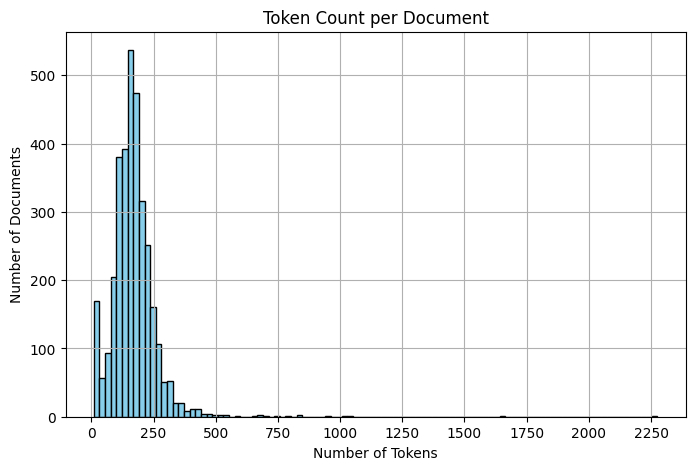

In [258]:
plt.figure(figsize=(8, 5))
plt.hist(courses['combined_text'].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Token Count per Document')
plt.xlabel('Number of Tokens')
plt.xticks(ticks=range(0, 2500, 250))
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

First we'll truncate courses that have a combined_text over 300:

In [259]:
courses["combined_text"] = courses["combined_text"].apply(lambda x: x[:300])

To remove noise, we will at this point filter out courses that have a combined text less than 30.

In [260]:
courses = courses[courses["combined_text"].apply(lambda x: len(x) >= 50)]
print(courses.shape)

(3133, 9)


Although this plot might look a bit weird, it is fine.

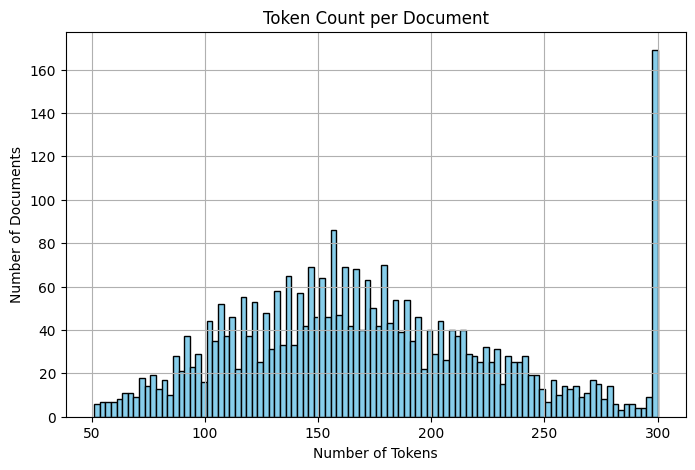

In [263]:
plt.figure(figsize=(8, 5))
plt.hist(courses['combined_text'].apply(len), bins=100, color='skyblue', edgecolor='black')
plt.title('Token Count per Document')
plt.xlabel('Number of Tokens')
plt.xticks(ticks=range(50, 301, 50))
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

Sources for this part of the code:
* https://www.nltk.org/api/nltk.tokenize.regexp.html
* https://www.kaggle.com/code/kanikanarang94/tokenization-using-nltk
* https://saturncloud.io/blog/how-to-combine-two-columns-in-a-pandas-dataframe/

### Vectorization

First we tag the "combined_text" column in order to be able to vectorize it with Doc2Vec.

In [264]:
tagged_data = [TaggedDocument(words=doc, tags=[cid]) for doc, cid in zip(courses['combined_text'], courses['course_catalogue_number'])]

In [265]:
print(tagged_data[0])

TaggedDocument<['competitive', 'cooperative', 'strategy', 'masters', 'business', 'administration', 'mba', 'institute', 'of', 'executive', 'programmes', 'completing', 'course', 'able', 'to', 'identify', 'use', 'different', 'schools', 'thought', 'strategic', 'management', 'based', 'solid', 'understanding', 'assumptions', 'strengths', 'weaknesses', 'critically', 'reflect', 'different', 'theories', 'perspectives', 'relation', 'competitive', 'cooperative', 'strategy', 'compare', 'alternative', 'views', 'select', 'apply', 'combine', 'analytical', 'tools', 'diagnosing', 'addressing', 'strategic', 'issues', 'business', 'network', 'level', 'reallife', 'cases', 'analyse', 'competitive', 'cooperative', 'coopetitive', 'strategies', 'organizations', 'assess', 'impact', 'changes', 'strategies', 'formulate', 'recommendations', 'improvement', 'adequately', 'analyse', 'external', 'internal', 'environment', 'organization', 'derive', 'relevant', 'insights', 'inform', 'strategic', 'decisionmaking', 'ident

Next we vectorise it using the Doc2Vec model:

In [268]:
params = {
    'vector_size': 150, # dimension of embeddings
    'window': 15, # window -/+ before and after focus word
    'epochs': 50, # number of iterations over the corpus
    'min_count': 5, # filter on words whose frequency is below this count
    'workers': -1, # how many cores to use
    'alpha': 0.05, # initial learning rate for SGD. This is lambda in the class notes
    'min_alpha': 0.0001,
    'seed': 24
}

model = Doc2Vec(**params)
  
model.build_vocab(tagged_data)

model.train(tagged_data, total_examples = model.corpus_count, epochs = model.epochs)

Sources for this part of the code (these sources are also relevent for the following part of this notebook):
* https://radimrehurek.com/gensim/models/doc2vec.html
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
* https://spotintelligence.com/2023/09/06/doc2vec/#What_is_Doc2Vec
* The parameters in the code were taken from the notebook where Word2Vec was introduced.

### Recommender

In [269]:
def recommend_courses(li_course_ids, model, courses_df, top_n=5):
    #getting the vectors in form the doc2vec model and making one vector out of all the courses in the li_course_ids
    vectors = [model.dv[tag] for tag in li_course_ids]
    
    av_vector = np.mean(vectors, axis=0).reshape(1, -1)
    
    all_vectors = np.array([model.dv[i] for i in range(len(model.dv)) if i not in li_course_ids])
    
    #calculating the cosine similarities and flattening them to one dimension
    cosine_sim = cosine_similarity(av_vector, all_vectors).flatten()
    
    #making the cosine similarities a list and sorting it
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #removing the courses from the sim_scores which were in the li_course_ids - might be worng
    index_to_id = courses_df['course_catalogue_number'].tolist()
    
    selected_indicies = [index_to_id.index(cid) for cid in li_course_ids if cid in index_to_id]
    
    sim_scores = [s for s in sim_scores if s[0] not in selected_indicies]
    
    #getting the top 5 courses from the similaritie scores - also might be wrong
    course_indices = [i[0] for i in sim_scores[:top_n]]
    
    
    #returning the 
    return courses_df.iloc[course_indices][['course_name', 'course_catalogue_number']]

Sources for this part of the code:
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
* https://numpy.org/doc/stable/reference/generated/numpy.matrix.flatten.html
* https://ioflood.com/blog/dataframe-to-list-pandas/#:~:text=You%20can%20use%20the%20toList,tolist()%20.&text=In%20the%20example%20above%2C%20we,1%2C%202%2C%203%5D.
* https://www.programiz.com/python-programming/methods/list/index

### Testing

Opening the test dataset:

In [270]:
majors = []
tracks = []
li_course_ids = []
with open("datasets/test_set.txt", 'r') as f:
    for l in f:
        if l[0] == '[':
            li_course_ids.append(eval(l))
        elif l.isupper():
            majors.append(l)
        elif l.islower():
            tracks.append(l)

In [271]:
print(majors[0])
print(tracks[0])
recommend_courses(li_course_ids[0], model, courses)

SCIENCE

math



,course_name,course_catalogue_number
1355,"[history, and, philosophy, of, the, humanities]",187421516Y
467,"[cern, research, project]",5354CERP6Y
142,"[aesthetics, and, metaphysics]",187421096Y
1077,"[european, security, politics]",73230269LY
1681,"[leading, digital, business, transformation]",6614ZB058Y


In [272]:
print(tracks[1])
recommend_courses(li_course_ids[1], model, courses)

biomed



,course_name,course_catalogue_number
2115,"[multilevel, politics, in, the, european, unio...",111221012Y
632,"[conservation, principles, and, practice, 5, p...",146421186Y
718,"[critical, debates, in, english, studies]",178421176Y
1922,"[masters, thesis, philosophy]",187419000Y
2277,"[philosophy, of, science, methodology]",774212001Y


In [273]:
print(tracks[2])
recommend_courses(li_course_ids[2], model, courses)

physics



,course_name,course_catalogue_number
2865,"[spirituality, and, religion, lived, practices]",153421066Y
164,"[algorithms, complexity]",5062ALCO6Y
1245,[galoistheorie],5122GALO6Y
1120,"[fashion, culture, and, media]",119221106Y
2089,"[modernism, and, postmodernism]",900227HUMY


In [274]:
print(tracks[3])
recommend_courses(li_course_ids[3], model, courses)

bio/environment



,course_name,course_catalogue_number
84,"[advanced, forensic, biology]",5274ADFB6Y
344,"[back, to, the, object, unfolding, case, studies]",129221136Y
3331,"[world, culture, conservation, and, communities]",146421736Y
2021,[metaphysics],136214143Y
2805,"[social, media, and, contemporary, issues]",159424032Y


In [275]:
print(tracks[4])
recommend_courses(li_course_ids[4], model, courses)

information/neuro



,course_name,course_catalogue_number
1273,"[geographies, of, inequality]",73421B008Y
1961,"[thesis, proposal, consumer, marketing]",6314M0548Y
1133,"[fieldwork, mas]",73940005AY
3087,"[theories, of, digital, business]",6614ZB036Y
2070,"[modelling, system, dynamics]",5294MOSD6Y


In [276]:
print(majors[1])
print(tracks[5])
recommend_courses(li_course_ids[5], model, courses)

SOCIAL SCIENCE

economics



,course_name,course_catalogue_number
1060,"[european, and, international, environmental, ...",111221656Y
3196,"[tutorial, rma, linguistics, and, communicatio...",176528036Y
729,"[crossmedia, research, seminar, i]",15942A000Y
3278,"[variation, and, change, in, scandinavian, lan...",184416096Y
1839,"[masters, internship, health, promotion, behav...",7204MSDHXY


In [277]:
print(tracks[6])
recommend_courses(li_course_ids[6], model, courses)

psychology/economics



,course_name,course_catalogue_number
1182,"[food, and, the, city]",5132FOTC6Y
1775,"[making, the, european, marketplace, capita, s...",111221766Y
43,"[academic, skills, premasters]",109221062Y
3335,"[writing, and, dissemination, course]",750501009Y
1433,"[integrated, coastal, dune, management]",5264ICDM6Y


In [278]:
print(tracks[7])
recommend_courses(li_course_ids[7], model, courses)

political science/law



,course_name,course_catalogue_number
2213,"[organic, chemistry]",51121ORC6Y
1112,"[extending, reality, design, and, applications...",77642K016Y
1442,"[interest, rate, models]",5374INRM6Y
264,"[artificial, intelligence, dreams, dangers, and]",118221126Y
1609,"[introduction, to, the, philosophy, of, mathem...",136213086Y


In [279]:
print(majors[2])
print(tracks[8])
recommend_courses(li_course_ids[8], model, courses)

HUMANITIES

history/philosophy



,course_name,course_catalogue_number
3289,"[violence, 3, structural, violence]",7013K334AY
2233,"[partnerships, for, sustainable, innovation]",6314M0505Y
2199,"[oil, politics, and, state, capitalism, in, the]",7324E111IY
1167,"[financial, institutions, and, banking]",6414M0155Y
2059,"[mixed, methods, design, and, analysis, course]",75250083IY


In [280]:
print(tracks[9])
recommend_courses(li_course_ids[9], model, courses)

cultural analysis



,course_name,course_catalogue_number
2644,"[research, project, and, research, paper]",19042E120Y
80,"[advanced, digital, economic, geography]",735420241Y
861,"[developmental, psychology]",7201705PXY
1751,"[machine, learning, for, psychologists]",7202BM09XY
1541,"[introduction, to, biology]",900152SCIY


In [281]:
print(tracks[10])
recommend_courses(li_course_ids[10], model, courses)

media/film



,course_name,course_catalogue_number
2860,"[spectroscopic, analysis]",5254SPAN6Y
1245,[galoistheorie],5122GALO6Y
1485,"[international, relations, theory, and, practice]",900161SSCY
2544,"[rereading, the, graphic, design, archiverefra...",145422146Y
3028,"[the, history, of, ideas]",9002600HUY


In [282]:
print(tracks[11])
recommend_courses(li_course_ids[11], model, courses)

art history/history



,course_name,course_catalogue_number
440,[capstone],900301CICY
1031,"[esg, skills, ii]",6614ZE008Y
463,[causality],5204CAUS6Y
2003,"[media, aesthetics]",119121002Y
1457,"[international, criminal, tribunals, procedura...",3854I1Q8GY


Sources for this part of the code:
* https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/